In [8]:
import pyemma

C:\Users\Seldon\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: This function is deprecated. Please call randint(0, 7 + 1) instead
C:\Users\Seldon\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
C:\Users\Seldon\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
C:\Users\Seldon\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


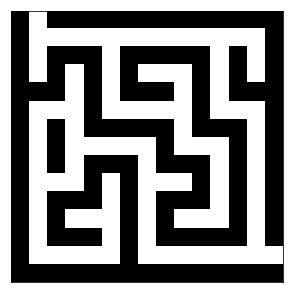

[[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 0 1 1 1 1 1 0 1 0 1]
 [1 0 1 0 1 0 1 0 0 0 1 0 1 0 1]
 [1 1 1 0 1 0 1 1 1 0 1 0 1 1 1]
 [1 0 0 0 1 0 0 0 0 0 1 0 0 0 1]
 [1 0 1 0 1 1 1 1 1 0 1 1 1 0 1]
 [1 0 1 0 0 0 0 0 1 0 0 0 1 0 1]
 [1 0 1 0 1 1 1 0 1 1 1 0 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 1 0 1 0 1]
 [1 0 1 1 1 0 1 0 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 1 0 1 0 0 0 1 0 1]
 [1 0 1 1 1 0 1 0 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [437]:
import numpy
from numpy.random import random_integers as randint
import matplotlib.pyplot as plt

def maze(width=50, height=50, complexity=.75, density=.75):
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1])))
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))
    # Build actual maze
    Z = numpy.zeros(shape, dtype=int)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    Z[0, 1] = Z[height-1,width] = 0
    # Make aisles
    for i in range(density):
        x, y = randint(0, shape[1] // 2) * 2, randint(0, shape[0] // 2) * 2
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[randint(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z
#    for x in range(width):
#        for y in range(height):
#           if Z[]
height=15
width=15
M=maze(height-1,width-1)
plt.figure(figsize=(5, 5))
plt.imshow(M, cmap=pyplot.cm.binary, interpolation='nearest')
plt.xticks([]), pyplot.yticks([])
plt.show()
print(M)

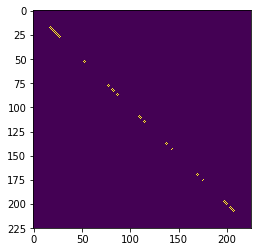

In [438]:
s=(height*width,width*height)
T=numpy.ones(s)

for i in range(width):
    for j in range(height):
        if M[i][j] == 1:
            for m in range(s[0]):
                for n in range(s[1]):
                    T[i*width+j][n]=0
                    T[m][i*width+j]=0
                    modm= m % 2
                    modn= n % 2
                    if modm==modn:
                        T[m][n]=0
    

for m in range(s[0]):
    for n in range(s[1]):
        if  abs(m-n)!=1:
            T[m][n]=0
plt.imshow(T)

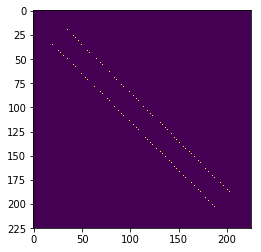

In [439]:
s=(height*width,width*height)
G=numpy.ones(s)

for i in range(width):
    for j in range(height):
        if M[i][j] == 1:
            for m in range(s[0]):
                for n in range(s[1]):
                    G[i*width+j][n]=0
                    G[m][i*width+j]=0
                    modm= m % 2
                    modn= n % 2
                    if modm==modn:
                        G[m][n]=0
    

for m in range(s[0]):
    for n in range(s[1]):
        if  abs(m-n)!=np.sqrt(height*width):
            G[m][n]=0
plt.imshow(G)

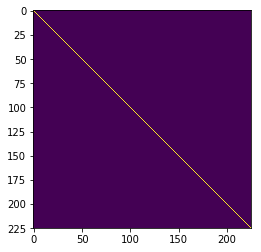

In [440]:
O=numpy.zeros(s)
for m in range(s[0]):
    for n in range(s[1]):
        if m==n:
            O[m][n]=1
plt.imshow(O)

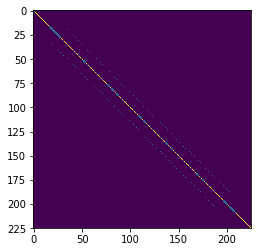

In [441]:
P=T+G+O
for row in range(P.shape[0]):
    P[row] /= np.sum(P[row])
P=np.nan_to_num(P)
plt.imshow(P)
#print(P.sum(axis=1))

In [442]:
import msmtools

In [443]:
msm = pyemma.msm.markov_model(msmtools.estimation.largest_connected_submatrix(P))
keptindices = msmtools.estimation.largest_connected_set(P)

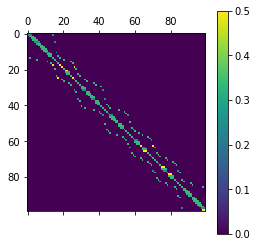

In [444]:
plt.matshow(msmtools.estimation.largest_connected_submatrix(P))
plt.colorbar()